In [1]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

# Create Neural Net

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [22]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils
from collections import deque

env = make("connectx", debug=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)

class ValueNetwork(nn.Module):
    def __init__(self, convFilters, filterSize, boardRows, boardCols):
        """
        Input board as 3 channel image.
        Convolutional Layer with ReLU and fully-connected output of one value.
        Args:
            convFilters: number of conv filter
            filterSize: Conv filter size (kernel size)
            boardRows: Number of rows for board
            boardCols: Number of cols for board
        """
        super().__init__()
        self.boardRows = boardRows
        self.boardCols = boardCols
        self.conv_feature_size = (boardRows-filterSize+1) * (boardCols-filterSize+1) * convFilters
        print(self.conv_feature_size)
        self.conv_layer1 = nn.Conv2d(1, convFilters, filterSize)
        self.fc1 = nn.Linear(self.conv_feature_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, board):
        """
        Args:
            board: serialized board from env observation (-1, 0, 1)
            Current player pieces is 1, opponent player pieces: -1
        Returns:
            The after state value
        """
        board = torch.Tensor(board).to(DEVICE)
        # Reshape
        board = board.view(1, self.boardCols, self.boardRows)
        s = F.relu(self.conv_layer1(board))
        s = s.flatten()
        s = F.sigmoid(self.fc1(s))
        s = F.sigmoid(self.fc2(s))
        
        output = torch.tanh(self.fc3(s))
        return output


cpu


# Helper functions

In [2]:
def get_valid_actions(env, board):
    return [c for c in range(env.configuration.columns) if board[c] == 0]

def simulate_play(board, column, config):
    EMPTY = 0
    columns = config.columns
    rows = config.rows
    row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
    nextBoard = board.copy()
    # Mark board as player 1
    nextBoard[column + (row * columns)] = 1
    return nextBoard

def policy(env, model, board):
    """
    Afterstate greedy policy using value network (model)
    """
    available_actions = get_valid_actions(env, board)
    bestValue = float('-inf')
    bestAction = None
    
    # Return action with best after state value
    for action in available_actions:
        nextBoard = simulate_play(board, action, env.configuration)
        actionValue = model(nextBoard)
        if actionValue > bestValue:
            bestValue = actionValue
            bestAction = action
    return bestAction

def training_policy(env, model, board, epsilon):
    """
    Afterstate epsilon greedy policy using value network (model)
    """
    # Explore
    if random.uniform(0, 1) < epsilon:
        available_actions = get_valid_actions(env, board)
        action = random.choice(available_actions)
    # Greedy
    else:
        action = policy(env, model, board)

    return action

def convert_board(board, mark):
    # Converts board into (-1, 0, 1) where current player is 1 and opponent -1
    board = np.array(board)
    for i in range(len(board)):
        if board[i] == 0:
            continue
        elif board[i] == mark:
            board[i] = 1
        else:
            board[i] = -1
    
    return board

def opponent_perspective_board(board):
    return board.copy() * -1

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Create Agent

In [3]:
# This agent random chooses a non-empty column.
def my_agent(observation, configuration):
    # Number of Columns on the Board: 7
    columns = configuration.columns
    # Number of Rows on the Board: 6
    rows = configuration.rows
    # Number of Checkers "in a row" needed to win: 4
    inarow = configuration.inarow
    # The current serialized Board (rows x columns).
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    
    board = convert_board(board, observation.mark)

    return policy(env, model, board)

# Set up train & experience replay

In [24]:
# Improvements needed
# 1) Normalize loss and value output
# 2) Separate model for Pred and Target (DONE)
# 3) Memory replay for more stability (DONE)
# 4) Possibly some rollout methods to look ahead
# 5) Decay in lr or epsilon (DONE)
# 6) Make nn layers more complex (DONE)
def train(model, target_model, optimizer, loss_func, episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay):
    # Cast model to cuda
    model = model.to(DEVICE)
    target_model = model.to(DEVICE)
    losses = []
    episode_losses = []
    epsilons = []
    win_rates = []
    experience_replay = deque(maxlen=max_exp_size)
    epsilon = epsilon_init
    steps = 0
    for episode in tqdm(range(episodes)):
        # for each episode
        epsilons.append(epsilon)
        env.reset()
        while not env.done:
            steps += 1
            # This is to enable self play
            active = -1
            if env.state[0].status == "ACTIVE":
                active=0
            if env.state[1].status == "ACTIVE":
                active=1
            
            observation = env.state[active].observation
            configuration = env.configuration
            curBoard = convert_board(observation.board, observation.mark)
            
            # Choose epsilon greedy action
            my_action = training_policy(env, model, curBoard, epsilon)
            # Step depending on who's turn is it for self play
            env.step([my_action if i==active else None for i in [0,1]])
            
            after_state_observation = env.state[active].observation
            # After state board
            s1 = convert_board(after_state_observation.board, observation.mark)
            
            # Reward
            reward = 0 
            if env.done:
                reward = 1
                # No after state when game is over
                s2 = None
            else:
                # Simulate next state from opponent
                opp_board = opponent_perspective_board(s1)
                nextMaxAction = policy(env, target_model, opp_board)
                s2 = simulate_play(opp_board, nextMaxAction, env.configuration)
            
            # Add to experience replay queue
            experience_replay.append([s1, s2, reward, env.done])
            
            # Update model network every BATCH from experience replay
            if steps % BATCH == 0:
                update_model_from_experience_replay(experience_replay, model, target_model, loss_func, losses)
            
            # Update target network every C_BATCH
            if steps % C_BATCH == 0:
                target_model.load_state_dict(model.state_dict())
        if (episode) % 500 == 0:
            # Run multiple episodes to estimate its performance.
            rewardFirst = mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=50))
            rewardSecond = mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=50))
            print(f"Trained {episode} episodes, {steps} steps. Going first: {rewardFirst}, going second: {rewardSecond}")
            win_rates.append((rewardFirst + rewardSecond)/ 2)
        episode_losses.append(np.mean(losses[-len(env.steps):]))
        epsilon = max(epsilon * epsilon_decay, epsilon_final)
    # Save weights
    torch.save({
        'model_state_dict': model.state_dict()
    }, MODEL_WEIGHTS_SAVE_PATH)
    print(f"\nTrained total {steps} steps")
    print(f"Last 100 steps loss average: {np.mean(losses[-100:])}")
    plt.plot(episode_losses, label="Episode MSE losses")
    plt.show()
    plt.plot(losses[100:], label="STEP MSE_Loss")
    plt.show()
    plt.plot(epsilons, label="Epsilons")
    plt.show()
    plt.plot(win_rates, label="Win rate against random agent")

def update_model_from_experience_replay(experience_replay, model, target_model, loss_func, losses):
    # Only start training after we have some experiences
    if len(experience_replay) < min_exp_size:
        return
    
    preds = []
    targets = []
    for s1, s2, reward, done in random.sample(experience_replay, BATCH):
        reward = torch.as_tensor(reward).to(DEVICE)
        # Current value of my after state (post action state)
        curAfterStateValue = model(s1)
        if not done:
            nextAfterStateValue = target_model(s2) * -1
        else:
            nextAfterStateValue = torch.zeros(1).to(DEVICE)
        
        preds.append(curAfterStateValue)
        targets.append((reward + nextAfterStateValue * gamma))
    
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    
    # Minibatch update
    loss = loss_func(torch.Tensor(preds), torch.Tensor(targets))
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() 
    
# Set up model and optimizer
MODEL_WEIGHTS_SAVE_PATH = './model_weights.pt'
numConvFilters = 32
filterSize = 4
# Create model and target model
# Input: after board state, player mark
# Output: Value of the after boardstate
# Model: main model updated every BATCH
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
#model.load_state_dict(torch.load(MODEL_WEIGHTS_SAVE_PATH)['model_state_dict'])
# Target model: updated every C_BATCH
target_model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
target_model.load_state_dict(model.state_dict())

lr = 0.01
optimizer = Adam(model.parameters(), lr=lr)
epsilon_init = 1.0
epsilon_final = 0.01
epsilon_decay = 0.99985
episodes = 20000
gamma = 0.999
# Steps to update model
BATCH = 32
# Steps to update target model
C_BATCH = BATCH * 10
# Experience replay min size to train
min_exp_size = BATCH * 10
max_exp_size = BATCH * 100

384
384


In [40]:
state = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,1,0,0,0],
         [0,0,0,1,0,0,-1],
         [0,0,0,1,0,0,-1],
         [0,0,0,1,0,0,-1],]
state = np.array(state).reshape(-1)
after_state_value = model(state)
print(after_state_value)

tensor([0.5042], grad_fn=<TanhBackward0>)


  0%|                                                 | 0/20000 [00:00<?, ?it/s]/Users/swbae/Desktop/Projects/ConnectXKaggle/venv/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|                                      | 1/20000 [00:16<93:10:37, 16.77s/it]

Trained 0 episodes, 35 steps. Going first: 0.48, going second: 0.5


  3%|▉                                   | 501/20000 [02:01<37:09:32,  6.86s/it]

Trained 500 episodes, 10344 steps. Going first: 0.62, going second: 0.54


  5%|█▊                                 | 1001/20000 [04:02<33:17:16,  6.31s/it]

Trained 1000 episodes, 20542 steps. Going first: 0.92, going second: 0.34


  8%|██▋                                | 1501/20000 [05:45<24:46:39,  4.82s/it]

Trained 1500 episodes, 30512 steps. Going first: 0.94, going second: 0.18


 10%|███▌                               | 2001/20000 [07:20<22:27:37,  4.49s/it]

Trained 2000 episodes, 39734 steps. Going first: 0.9, going second: 0.14


 13%|████▍                              | 2501/20000 [08:48<17:38:29,  3.63s/it]

Trained 2500 episodes, 48184 steps. Going first: 0.96, going second: 0.18


 15%|█████▎                             | 3002/20000 [10:15<11:18:15,  2.39s/it]

Trained 3000 episodes, 56612 steps. Going first: 0.94, going second: 0.1


 18%|██████▏                            | 3501/20000 [11:46<18:08:43,  3.96s/it]

Trained 3500 episodes, 65159 steps. Going first: 0.98, going second: 0.1


 20%|███████                            | 4001/20000 [13:10<11:37:56,  2.62s/it]

Trained 4000 episodes, 73164 steps. Going first: 1.0, going second: 0.04


 23%|███████▉                           | 4501/20000 [14:35<16:25:35,  3.82s/it]

Trained 4500 episodes, 81082 steps. Going first: 0.94, going second: 0.1


 25%|████████▊                          | 5001/20000 [16:14<14:26:49,  3.47s/it]

Trained 5000 episodes, 89229 steps. Going first: 0.98, going second: 0.02


 28%|█████████▋                         | 5501/20000 [18:34<15:42:10,  3.90s/it]

Trained 5500 episodes, 97199 steps. Going first: 1.0, going second: 0.04


 30%|██████████▌                        | 6001/20000 [20:06<16:27:54,  4.23s/it]

Trained 6000 episodes, 105323 steps. Going first: 0.98, going second: 0.14


 33%|███████████▍                       | 6501/20000 [21:41<13:09:06,  3.51s/it]

Trained 6500 episodes, 113512 steps. Going first: 0.96, going second: 0.12


 35%|████████████▎                      | 7001/20000 [23:40<21:31:25,  5.96s/it]

Trained 7000 episodes, 121747 steps. Going first: 1.0, going second: 0.04


 38%|█████████████▏                     | 7501/20000 [26:57<18:12:04,  5.24s/it]

Trained 7500 episodes, 129930 steps. Going first: 0.9, going second: 0.18


 40%|██████████████                     | 8001/20000 [29:13<20:11:05,  6.06s/it]

Trained 8000 episodes, 138763 steps. Going first: 0.98, going second: 0.06


 43%|██████████████▉                    | 8501/20000 [31:19<16:48:01,  5.26s/it]

Trained 8500 episodes, 147257 steps. Going first: 0.92, going second: 0.14


 45%|███████████████▊                   | 9001/20000 [33:33<20:30:32,  6.71s/it]

Trained 9000 episodes, 156322 steps. Going first: 0.96, going second: 0.1


 48%|████████████████▋                  | 9501/20000 [35:46<20:58:48,  7.19s/it]

Trained 9500 episodes, 165107 steps. Going first: 0.96, going second: 0.06


 50%|█████████████████                 | 10001/20000 [38:07<16:20:46,  5.89s/it]

Trained 10000 episodes, 174282 steps. Going first: 0.98, going second: 0.06


 53%|█████████████████▊                | 10501/20000 [40:09<10:34:20,  4.01s/it]

Trained 10500 episodes, 182604 steps. Going first: 0.88, going second: 0.08


 55%|██████████████████▋               | 11001/20000 [42:24<16:32:52,  6.62s/it]

Trained 11000 episodes, 191708 steps. Going first: 0.98, going second: 0.06


 58%|████████████████████▏              | 11501/20000 [44:12<9:26:59,  4.00s/it]

Trained 11500 episodes, 200556 steps. Going first: 0.96, going second: 0.16


 60%|████████████████████▍             | 12001/20000 [46:20<13:29:34,  6.07s/it]

Trained 12000 episodes, 209033 steps. Going first: 0.88, going second: 0.08


 63%|█████████████████████▉             | 12501/20000 [48:08<9:11:00,  4.41s/it]

Trained 12500 episodes, 218516 steps. Going first: 1.0, going second: 0.04


 65%|██████████████████████            | 13001/20000 [50:00<10:55:24,  5.62s/it]

Trained 13000 episodes, 228204 steps. Going first: 1.0, going second: 0.04


 68%|███████████████████████▋           | 13501/20000 [51:59<8:40:20,  4.80s/it]

Trained 13500 episodes, 238868 steps. Going first: 0.9, going second: 0.08


 70%|████████████████████████▌          | 14001/20000 [53:58<8:23:43,  5.04s/it]

Trained 14000 episodes, 249616 steps. Going first: 0.9, going second: 0.02


 73%|█████████████████████████▍         | 14502/20000 [55:45<5:24:39,  3.54s/it]

Trained 14500 episodes, 258759 steps. Going first: 0.96, going second: 0.08


 75%|████████████████████████▊        | 15001/20000 [1:18:07<4:41:25,  3.38s/it]

Trained 15000 episodes, 268078 steps. Going first: 0.96, going second: 0.06


 78%|█████████████████████████▌       | 15501/20000 [1:19:44<5:19:57,  4.27s/it]

Trained 15500 episodes, 277506 steps. Going first: 0.98, going second: 0.06


 80%|██████████████████████████▍      | 16001/20000 [1:21:23<3:45:49,  3.39s/it]

Trained 16000 episodes, 286245 steps. Going first: 0.98, going second: 0.1


 83%|███████████████████████████▏     | 16502/20000 [1:23:40<3:16:11,  3.37s/it]

Trained 16500 episodes, 295346 steps. Going first: 0.94, going second: 0.14


 85%|████████████████████████████     | 17001/20000 [1:25:46<4:47:49,  5.76s/it]

Trained 17000 episodes, 303860 steps. Going first: 0.98, going second: 0.08


 88%|████████████████████████████▉    | 17501/20000 [1:27:45<4:16:02,  6.15s/it]

Trained 17500 episodes, 311548 steps. Going first: 0.88, going second: 0.04


 90%|█████████████████████████████▋   | 18001/20000 [1:29:39<4:14:26,  7.64s/it]

Trained 18000 episodes, 318325 steps. Going first: 0.8, going second: 0.18


 93%|██████████████████████████████▌  | 18501/20000 [1:31:37<3:16:43,  7.87s/it]

Trained 18500 episodes, 325237 steps. Going first: 0.88, going second: 0.14


 95%|███████████████████████████████▎ | 19001/20000 [1:33:44<2:24:26,  8.68s/it]

Trained 19000 episodes, 332727 steps. Going first: 0.87, going second: 0.13


 98%|████████████████████████████████▏| 19501/20000 [1:36:33<1:20:16,  9.65s/it]

Trained 19500 episodes, 344091 steps. Going first: 0.74, going second: 0.16


100%|███████████████████████████████████| 20000/20000 [1:38:47<00:00,  3.37it/s]



Trained total 353818 steps
Last 100 steps loss average: 0.035636539827061144


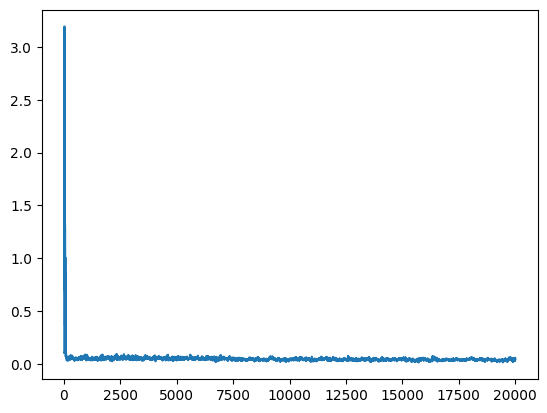

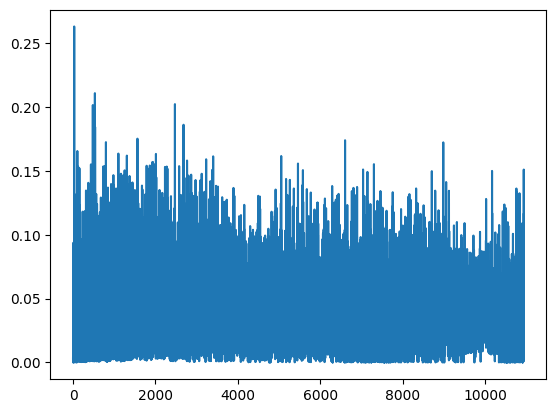

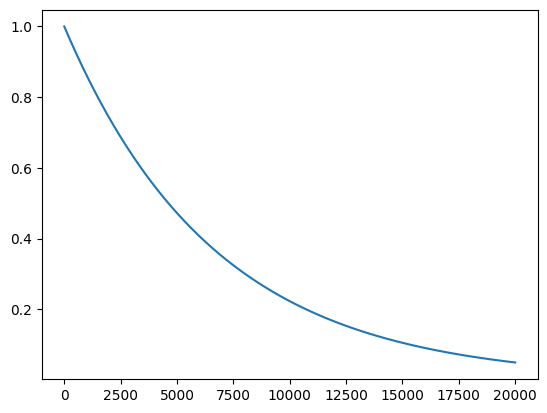

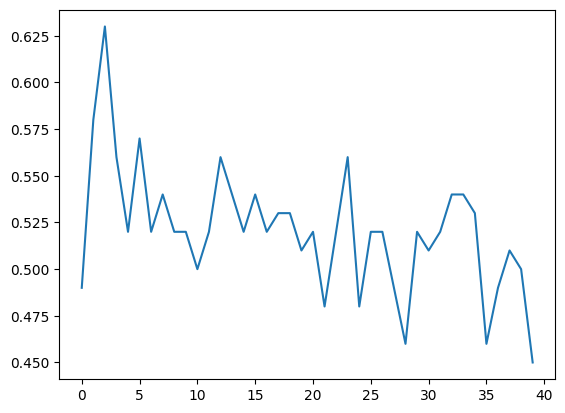

In [25]:
# Start Training
train(model, target_model, optimizer, nn.MSELoss(), episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay)

In [48]:
# Load Model
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
#model.load_state_dict(torch.load(MODEL_WEIGHTS_SAVE_PATH, map_location=torch.device('cpu'))['model_state_dict'])

# Test Agent

In [51]:
env.reset()
# Play as the first agent against default "random" agent.
env.run(["random", my_agent])
env.render(mode="ipython", width=500, height=450)

# Evaluate your Agent

In [43]:
# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=100)))
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=100)))

#print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.89
My Agent vs Random Agent: 0.23


# Play your Agent
Click on any column to place a checker there ("manually select action").

In [42]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, my_agent], width=500, height=450)

# Write Submission File



In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.